# README
This notebook is used to split the dataset.

In [5]:
import numpy as np
import pickle
import pandas as pd
import numpy as np
import random
import os
import json
import matplotlib.pyplot as plt
from batteryml.data.battery_data import BatteryData
random.seed(2024)
np.random.seed(2024)

# RWTH dataset

In [6]:
# Here is the train_ids provided by BatteryML
data_path = '/data/trf/python_works/Battery-LLM/dataset/RWTH'
tmp_files = os.listdir(data_path)
life_labels = json.load(open('/data/trf/python_works/Battery-LLM/dataset/RWTH_labels.json'))
files = [i for i in tmp_files if i in life_labels]

test_ratio = 0.2
testing_set = random.sample(files, int(len(files)*0.2))
training_set = [i for i in files if i not in testing_set]

val_ratio = 0.2

validation_set= random.sample(training_set, int(len(training_set)*0.25))
training_set = [i for i in training_set if i not in validation_set]


assert len(training_set) + len(validation_set) + len(testing_set) == len(files)

print(f'training_set: {len(training_set)} {training_set}')
print(f'Val set: {len(validation_set)} {validation_set}')
print(f'Test set: {len(testing_set)} {testing_set}')

training_set: 30 ['RWTH_016.pkl', 'RWTH_045.pkl', 'RWTH_009.pkl', 'RWTH_039.pkl', 'RWTH_046.pkl', 'RWTH_019.pkl', 'RWTH_037.pkl', 'RWTH_013.pkl', 'RWTH_003.pkl', 'RWTH_044.pkl', 'RWTH_026.pkl', 'RWTH_006.pkl', 'RWTH_031.pkl', 'RWTH_036.pkl', 'RWTH_048.pkl', 'RWTH_033.pkl', 'RWTH_021.pkl', 'RWTH_012.pkl', 'RWTH_034.pkl', 'RWTH_018.pkl', 'RWTH_022.pkl', 'RWTH_030.pkl', 'RWTH_028.pkl', 'RWTH_011.pkl', 'RWTH_040.pkl', 'RWTH_041.pkl', 'RWTH_042.pkl', 'RWTH_025.pkl', 'RWTH_047.pkl', 'RWTH_004.pkl']
Val set: 9 ['RWTH_007.pkl', 'RWTH_032.pkl', 'RWTH_024.pkl', 'RWTH_002.pkl', 'RWTH_029.pkl', 'RWTH_010.pkl', 'RWTH_027.pkl', 'RWTH_014.pkl', 'RWTH_049.pkl']
Test set: 9 ['RWTH_038.pkl', 'RWTH_008.pkl', 'RWTH_035.pkl', 'RWTH_017.pkl', 'RWTH_015.pkl', 'RWTH_023.pkl', 'RWTH_020.pkl', 'RWTH_005.pkl', 'RWTH_043.pkl']


In [4]:
def resample_charge_discharge_curves(voltages, capacity, is_discharge=False):
    '''
    resample the charge and discharge curves
    :param voltages:charge or dicharge voltages
    :param capacity: capacity
    :is_discharge: set True means data comes from discharging
    :return:interploted records
    '''
    charge_discharge_len = 300 // 2
    capacity = capacity / max(capacity) # normalize the capacity into [0, 1]
    
    outlier_flag = True
    while outlier_flag:
        roll_capacity = np.roll(capacity, shift=1)
        roll_capacity[0] = -np.inf
        mask = capacity >= roll_capacity
        if np.all(mask):
            outlier_flag = False
        else:
            # some capacity records are not strictly increasing
            capacity = capacity[mask]
            voltages = voltages[mask]

    interp_capacity = np.linspace(0, 1, num=charge_discharge_len, endpoint=True)
    interp_voltages = np.interp(interp_capacity, capacity, voltages)
    return interp_voltages, interp_capacity

RWTH


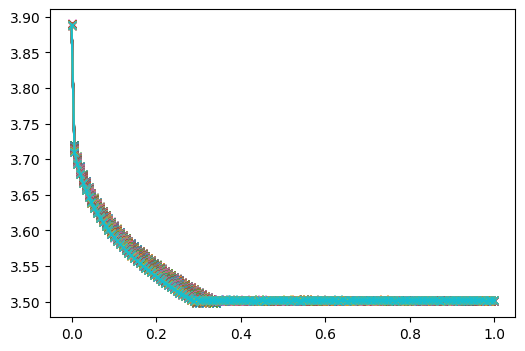

In [7]:
data_path = '../dataset/RWTH/RWTH_008.pkl'
data = pickle.load(open(data_path, 'rb'))
is_discharge = True
#data = pickle.load(open('../dataset/HUST/HUST_7-5.pkl', 'rb'))
cycle_data = data['cycle_data']
nominal_capacity = data['nominal_capacity_in_Ah']
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
prefix = data_path.split('/')[2]
print(prefix)
fig = plt.figure(figsize=(6,4))
for correct_cycle_index, sub_cycle_data in enumerate(cycle_data[:100]):
    cycle_df = pd.DataFrame()
    for key in need_keys:
        cycle_df[key] = sub_cycle_data[key]    
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df.loc[cycle_df['charge_capacity_in_Ah']<0] = np.nan
    cycle_df.bfill(inplace=True) # deal with NaN
    voltage_records = cycle_df['voltage_in_V'].values
    current_records = cycle_df['current_in_A'].values
    current_records_in_C = current_records/nominal_capacity
    charge_capacity_records = cycle_df['charge_capacity_in_Ah'].values
    discharge_capacity_records = cycle_df['discharge_capacity_in_Ah'].values

    cutoff_voltage_indices = np.nonzero(current_records_in_C>=0.01) # This includes constant-voltage charge data, 49th cycle of MATR_b1c18 has some abnormal voltage records
    charge_end_index = cutoff_voltage_indices[0][-1] # after charge_end_index, there are rest after charge, discharge, and rest after discharge data

    cutoff_voltage_indices = np.nonzero(current_records_in_C<=-0.01) 
    discharge_end_index = cutoff_voltage_indices[0][-1]
    
    # tmp_discharge_capacity_records = max(charge_capacity_records) - discharge_capacity_records
    if prefix in ['RWTH', 'OX']:
        # Every cycle first discharge and then charge
        #capacity_in_battery = np.where(charge_capacity_records==0, discharge_capacity_records, charge_capacity_records)
        discharge_voltages = voltage_records[:discharge_end_index]
        discharge_capacities = discharge_capacity_records[:discharge_end_index]
        discharge_currents = current_records[:discharge_end_index]
        
        charge_voltages = voltage_records[discharge_end_index:]
        charge_capacities = charge_capacity_records[discharge_end_index:]
        charge_currents = current_records[discharge_end_index:]
        charge_current_in_C = charge_currents / nominal_capacity
        
        charge_voltages = charge_voltages[np.abs(charge_current_in_C)>0.01]
        charge_capacities = charge_capacities[np.abs(charge_current_in_C)>0.01]
        charge_currents = charge_currents[np.abs(charge_current_in_C)>0.01]
    else:
        # Every cycle first charge and then discharge
        #capacity_in_battery = np.where(np.logical_and(current_records>=-(nominal_capacity*0.01), discharge_capacity_records<=nominal_capacity*0.01), charge_capacity_records, discharge_capacity_records)
        discharge_voltages = voltage_records[charge_end_index:]
        discharge_capacities = discharge_capacity_records[charge_end_index:]
        discharge_currents = current_records[charge_end_index:]
        discharge_current_in_C = discharge_currents / nominal_capacity
        
        discharge_voltages = discharge_voltages[np.abs(discharge_current_in_C)>0.01]
        discharge_capacities = discharge_capacities[np.abs(discharge_current_in_C)>0.01]
        discharge_currents = discharge_currents[np.abs(discharge_current_in_C)>0.01]
        
        charge_voltages = voltage_records[:charge_end_index]
        charge_capacities = charge_capacity_records[:charge_end_index]
        charge_currents = current_records[:charge_end_index]

    if is_discharge:
        #plt.plot(discharge_capacities, discharge_voltages, marker='o')
        discharge_voltages, discharge_capacities = resample_charge_discharge_curves(discharge_voltages, discharge_capacities, is_discharge=True)
        plt.plot(discharge_capacities, discharge_voltages, marker='x')
    else:
        #plt.plot(charge_capacities, charge_voltages, marker='o')
        charge_voltages, charge_capacities = resample_charge_discharge_curves(charge_voltages, charge_capacities, is_discharge=True)
        plt.plot(charge_capacities, charge_voltages, marker='x')
    # plt.plot(current_records, marker='o', label='current')
    # plt.plot(cycle_df['charge_capacity_in_Ah'].values, marker='o', label='charge Q')
    # plt.plot(cycle_df['discharge_capacity_in_Ah'].values, marker='o', label='discharge Q')

plt.show()